In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import catboost as cb # Import CatBoost
import shap
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import roc_auc_score, roc_curve

# Reproducibility seeds
np.random.seed(87)

In [2]:
# --- Data Loading and Preprocessing ---
df = pd.read_csv('cleaned_casedata.csv')

In [3]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)

# --- Feature Engineering (Same as before) ---
ext_source_cols = ['EXT_SOURCE_2', 'EXT_SOURCE_3']
df['EXT_SOURCE_AVG'] = df[ext_source_cols].mean(axis=1)

# Drop columns
# Note: 'Unnamed: 0' is likely an old index column saved to the CSV.
# The EXT_SOURCE columns are often very predictive, but we will follow the original script's removal.
#if 'Unnamed: 0' in df.columns:
 #   df = df.drop(['Unnamed: 0'], axis=1)
if 'EXT_SOURCE_2' in df.columns and 'EXT_SOURCE_3' in df.columns:
  df = df.drop(['EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)

In [4]:
# --- KEY CHANGE: Let CatBoost Handle Categorical Features Natively ---
# We will NOT use pd.get_dummies(). Instead, we'll identify categorical columns
# and pass them directly to the model.

X = df.drop(columns=["TARGET"])
Y = df["TARGET"]

 #--- KEY CHANGE: More Robust Imputation Step ---
# Identify categorical and numerical columns from the feature set X
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print("Imputing missing values...")
# Fill missing values in categorical columns with the string 'Missing'
X[categorical_features] = X[categorical_features].fillna('Missing')

# Fill missing values in numerical columns with their respective medians
X[numerical_features] = X[numerical_features].fillna(X[numerical_features].median())

# Verification step: Ensure no missing values remain
assert X.isnull().sum().sum() == 0, "Error: Missing values still exist after imputation!"
print("Successfully handled all missing values.")

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=99,
    shuffle=True,
    stratify=Y
)

# Get the column indices of categorical features for CatBoost
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]


Imputing missing values...
Successfully handled all missing values.


In [5]:
# --- CatBoost Model Training and Tuning ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# KEY CHANGE 2: Define the CatBoost model in the pipeline
# We will pass the categorical features to the model during the .fit() step
cat_pipe = Pipeline([
    ("model", cb.CatBoostClassifier(
        # Handles imbalance automatically and effectively
        auto_class_weights='Balanced',
        random_state=99,
        # Suppress verbose output during grid search
        silent=True
    ))
])

# KEY CHANGE 3: Create a hyperparameter grid specific to CatBoost
param_grid = {
    'model__iterations': [300, 500], # Number of trees (like n_estimators)
    'model__depth': [4, 6],          # Depth of the trees
    'model__learning_rate': [0.05, 0.1],
    'model__l2_leaf_reg': [3, 5]     # L2 regularization
}

# Run cross-validated grid search with the new CatBoost pipeline
cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    verbose=1
)

# KEY CHANGE 4: Pass categorical feature indices to the .fit() method
# This tells the pipeline to inform CatBoost which columns to treat as categorical
cat_cv.fit(X_train, Y_train, model__cat_features=cat_features_indices)


print("\nBest params selected by CV:", cat_cv.best_params_)
print("Best CV ROC-AUC:", round(cat_cv.best_score_, 3))

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best params selected by CV: {'model__depth': 4, 'model__iterations': 300, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.05}
Best CV ROC-AUC: 0.73



Top 15 features:
                       feature  importance
41              EXT_SOURCE_AVG   24.658173
8              AMT_GOODS_PRICE    7.067368
42                         AGE    6.533240
7                  AMT_ANNUITY    6.259435
6                   AMT_CREDIT    5.957478
15               DAYS_EMPLOYED    3.931968
44            ID_PUBLISH_YEARS    3.395307
0           NAME_CONTRACT_TYPE    3.184279
14  REGION_POPULATION_RELATIVE    3.102055
43          REGISTRATION_YEARS    2.659518
11         NAME_EDUCATION_TYPE    2.592623
1                  CODE_GENDER    2.530343
10            NAME_INCOME_TYPE    2.461657
34      DAYS_LAST_PHONE_CHANGE    2.374633
5             AMT_INCOME_TOTAL    2.283729


<Figure size 1000x700 with 0 Axes>

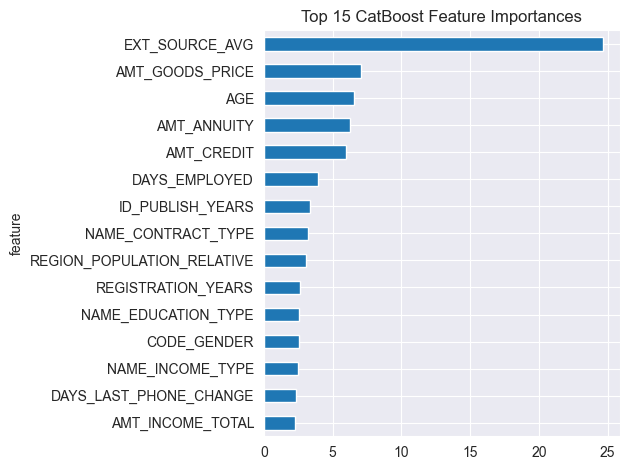

In [6]:
# --- Feature Importance Plot ---
best_cat = cat_cv.best_estimator_.named_steps["model"]
importances = best_cat.get_feature_importance()
features = X_train.columns

feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 15 features:")
print(feat_imp.head(15))

plt.figure(figsize=(10, 7))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 CatBoost Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ROC AUC on Test Set: 0.735


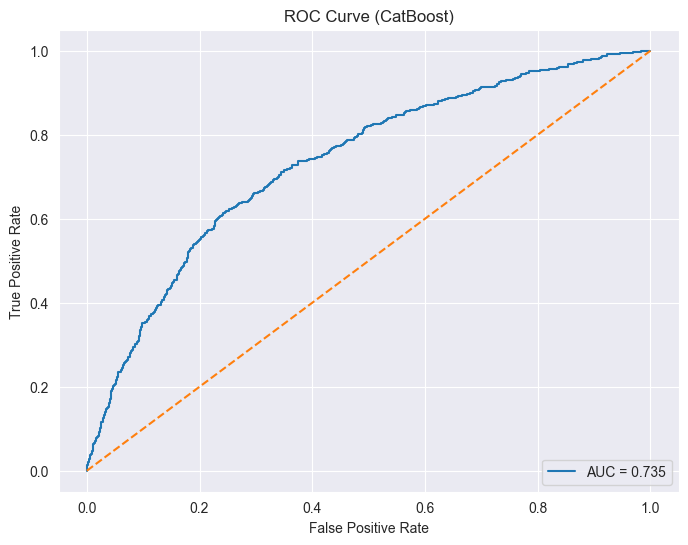

In [7]:
# --- ROC Curve and AUC Score ---
proba = cat_cv.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, proba)
print(f"\nROC AUC on Test Set: {roc_auc:.3f}")

fpr, tpr, _ = roc_curve(Y_test, proba, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (CatBoost)")
plt.legend(loc="lower right")
plt.show()


--- Generating SHAP Analysis ---
Generating SHAP summary plot...


C:\Users\miyee\AppData\Local\Temp\ipykernel_16636\2252033329.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


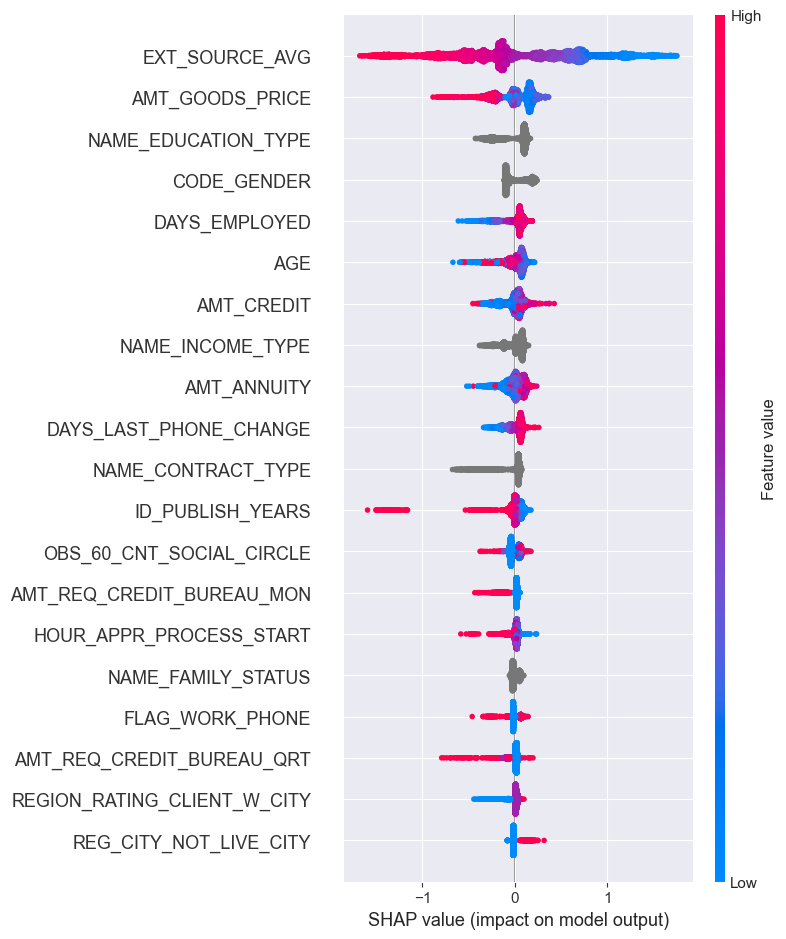

In [8]:
# --- SHAP Analysis ---
print("\n--- Generating SHAP Analysis ---")

explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_test)

print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test)
